In [2]:
from main_model.Model import get_main_model
import pandas as pd
import numpy as np
import shap

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/porosenok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# 
class Driver:
    def __init__(self, id, main_df, comment_df, tracks_df, model):
        '''
        id - driver id
        initial_orders_data - all the driver's orders
        model - catboost model for agressivness prediction
        '''
        
        self.id: str= id
        self.order_default = 100

        self.main_df = main_df
        self.comment_df = comment_df
        self.tracks_df = tracks_df
        self.orders_data = main_df

        self.n_of_orders = 0
        self.orders_ratings = []
        self.dates = []
        self.coefficients = {'total_agressivness':1, 'speed_limit_ignorance':100 }

        self.main_model = model
        self.score = 0.0


        for order_id in self.orders_data['order_id'].unique():
            order_data = self.orders_data[self.orders_data['order_id']==order_id]
            comment_data= self.comment_df[self.comment_df['order_id']==order_id]
            tracks_data = self.tracks_df[self.tracks_df['order_id']==order_id]
            self.add_order(order_data, comment_data, tracks_data)

    def get_score(self, order_aggressivness, violations_percentage):
        '''
        order_aggressivness: probability of an order being aggressive, predicted by catboost
        violations_percentage: total of disregards of speed limit in the order devided by all coord. points in the order's data
        '''
        result_coef= (order_aggressivness*self.coefficients['total_agressivness'] + self.coefficients['speed_limit_ignorance']*violations_percentage)/2
        result_rating = self.order_default - (result_coef*self.order_default)

        self.orders_ratings.append(result_rating)
        self.score = sum(self.orders_ratings)/self.n_of_orders

        return self.score

    def add_order(self, main_order_data: pd.DataFrame,comment_order_data: pd.DataFrame,track_order_data: pd.DataFrame):
        '''extracts features from order's data 
           and appends it to self.features
        '''
        features = {'agressivness':0.0, 'speed_limit_ignorance':0.0}

        main_order_data['client_rate_ride'].fillna(0)

        date = main_order_data.date
        self.dates.append(date)
        self.n_of_orders+=1

        #print(rate)
        transformed, order_aggressivness = self.main_model.predict_proba(main_order_data, comment_order_data, track_order_data)
        #print(order_aggressivness)
        order_aggressivness = round(order_aggressivness[0][1], 2) # probability of being agressive
        features['agressivness'] =  order_aggressivness
        features['violations_percentage']=transformed['violations_percentage'][0]

        score = self.get_score(order_aggressivness, features['violations_percentage'])
        #print(f'SCORE {score}')
        #print(f'Rate {rate} Aggressivness {order_aggressivness}')


        #shap.initjs()
        transformed = transformed.drop(['is_aggressive'], axis=1)
        shap_values = self.main_model.explainer.shap_values(transformed)
        shap.summary_plot(shap_values, feature_names=transformed.columns)

In [43]:
from os.path import exists
class Rating:
    def __init__(self, model, initial_df=None, initial_comment_df=None, initial_tracks_df=None, ):
        self.drivers = []
        self.main_df = initial_df
        self.main_df['date']=pd.to_datetime(self.main_df['date'])
        self.comment_df = initial_comment_df
        self.tracks_df = initial_tracks_df
        self.model = model
        self.add_order(self.main_df, self.comment_df, self.tracks_df)
        self.rating_path = './rating.csv'

    def add_order(self, main_df, comment_df, tracks_df):
        for driver_id in self.main_df['driver_id'].unique():

            # append a driver with all his orders from initial data to the driver list 
            driver  = Driver(driver_id, 
                             main_df[main_df['driver_id']==driver_id], 
                             comment_df[comment_df['driver_id']==driver_id],
                             tracks_df[tracks_df['driver_id']==driver_id], self.model)
            print(driver.id)
            self.drivers.append(driver)
    
    
    def save_rating(self):
        # scores for every order a driver made
        rating = pd.DataFrame({'score':[score for score in [driver.orders_ratings for driver in self.drivers]],
                               'driver_id': [driver.id for driver in self.drivers],
                               'date':[date for date in [driver.dates[0].tolist()[0] for driver in self.drivers]]})
        if exists(self.rating_path):
            rating_cached = pd.read_csv(self.rating_path, index_col=[0])
            rating_cached['date'] = pd.to_datetime(rating_cached['date'])
            res_rating = pd.concat((rating_cached, rating), ignore_index=True)
            res_rating.to_csv(self.rating_path)
        else:
            rating.to_csv(self.rating_path)
        #self.drivers.clear()

    def output_rating(self):
        rating = pd.read_csv(self.rating_path)
        #print(rating.head())
        #rating['score']=rating['score'].apply(lambda x: print(x.score))
        #rating['date']=pd.to_datetime(rating['date'])

        #dates = dates.sort()
        #rating = rating.loc[(rating['date']>dates[0]) & (rating['date']<dates[1])]
        #rating = rating.last('1W')
        return rating

In [24]:
path = './'
train_labled = pd.read_csv(path + 'data/base_files/labled_train_data.csv', index_col=0, sep='\t', comment='#')
tracks_labled = pd.read_csv(path+"data/labled_train_tracks_speed.csv", index_col=0, sep=',', comment='#')
tracks_unlabled = pd.read_csv(path +"data/unlabled_train_tracks_speed.csv", index_col=0, sep=',', comment='#')

test_tracks = pd.read_csv(path +"data/test_tracks_speed.csv", index_col=0, sep=',', comment='#')
test_data = pd.read_csv(path +"data/base_files/labled_test_data.csv", index_col=0, sep='\t', comment='#')
test_comments = test_data[['driver_id','comment']]

labled_train_comments = pd.read_csv('data/base_files/labled_train_comments.csv', comment='#', sep='\t').drop('Unnamed: 0', axis=1)

X_ = train_labled
y_ = train_labled.iloc[:, -1:]
X_['client_rate_ride'] = X_['client_rate_ride'].fillna(X_['client_rate_ride'].mean())
X_['client_rides_cnt'] = X_['client_rides_cnt'].fillna(X_['client_rides_cnt'].mean())
X_['driver_rides_cnt'] = X_['driver_rides_cnt'].fillna(X_['driver_rides_cnt'].mean())

#test_df = train_labled[['is_aggressive'==1]].iloc[:, 5].concat(train_labled[['is_aggressive'==1]].iloc[:, 5])

test_df=train_labled
test_df = train_labled[train_labled['driver_id']=='2f834441377ae067438c136c9d1f1781'].iloc[:3]
#aggressive= train_labled[train_labled['is_aggressive']==1].iloc[1]
#p
#test_df = pd.concat((test_df,aggressive), ignore_index=True)
#test_df['driver_id']='2f834441377ae067438c136c9d1f1781'

test_track = tracks_labled[tracks_labled['order_id'].isin(test_df['order_id'].tolist())]
test_comment = test_df[['comment', 'driver_id', 'order_id']]
model = get_main_model(test_df, test_tracks, test_comment)

In [7]:
test_df

,order_id,driver_id,client_id,dttm,date,arrived_distance,arrived_duration,distance,duration,from_latitude,from_longitude,to_latitude,to_longitude,mark,client_rate_ride,client_rides_cnt,driver_rides_cnt,comment,is_aggressive
204,83e5a174128f52691e30ccbcb5c835fc,2f834441377ae067438c136c9d1f1781,7f9dcccfcb47b2bfe9967f17a68863ea,2021-01-27 16:41:00,2021-01-27,30.0,0.0,2.7,6.7,55.782712,37.575552,55.791068,37.543133,Kia Ceed,5.0,25.789991,7.0,"Всё супер!\nЛучше, чем обычно.",0


Feature Extraction: 100%|██████████| 2/2 [00:00<00:00, 22.05it/s]


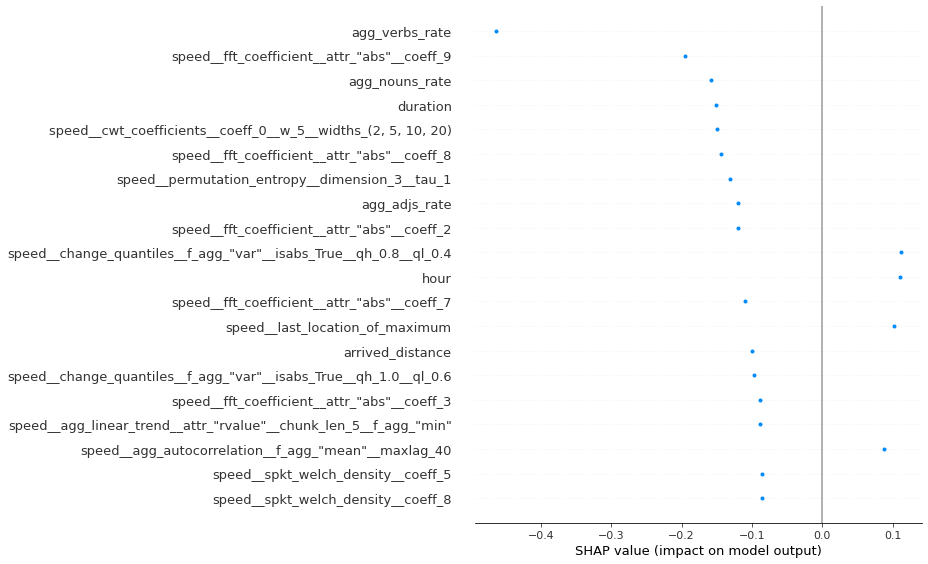

2f834441377ae067438c136c9d1f1781


,Unnamed: 0,score,driver_id,date
0,0,[96.0],2f834441377ae067438c136c9d1f1781,2021-01-27 00:00:00
1,1,[95.0],f7c2b293ef94420f5e51abae6889b83b,2021-01-22 00:00:00
2,2,[96.5],01d029c42c99581080a60679fca06ff9,2021-01-24 00:00:00
3,3,[95.5],3c88deb7df7a73a24ebc229db9783405,2021-01-26 00:00:00
4,4,[97.5],f35a8ff85f2095755f16bba91035fbdc,2021-01-27 00:00:00
...,...,...,...,...
883,883,[97.5],592b416796ae08e87a1c8ec6cea9cea0,2021-01-31 00:00:00
884,884,[93.0],a09fd185a023e87870630f0203701a62,2021-01-28 00:00:00
885,885,[98.5],3610445475a689b47ae3c57d1d79ba56,2021-01-29 00:00:00
886,886,[97.0],7d13d87693ce05c2b914ed639cd4dd15,2021-01-24 00:00:00


In [44]:
import datetime
rating = Rating(model, test_df, test_comment, test_track)
#rating.save_rating()
date1=(2021,1,27)
date2=(2021,2,27)
#print(datetime.date.fromisoformat('2021-01-27'))
#rating.output_rating([pd.to_datetime('2021-01-27'), pd.to_datetime('2021-02-27')])
rating.output_rating()